# H₂: VQE vs QPE — From Scratch

This notebook implements **VQE** and **QPE** for H₂ *from first principles* using PennyLane primitives.

Goals:
- Show the **core algorithms** with no abstraction layers
- Make every quantum step explicit
- Contrast the philosophy of VQE vs QPE

This notebook deliberately:
- does NOT use the vqe/ or qpe/ package APIs
- does NOT cache results
- does NOT hide circuit structure

It is intended for **learning**, not production use.

## Imports

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
import matplotlib.pyplot as plt


## Build H₂ Hamiltonian

We work in STO-3G at the equilibrium bond length.

In [4]:
symbols = ["H", "H"]
coordinates = np.array(
    [
        [0.0, 0.0, 0.0],
        [0.0, 0.0, 0.7414],
    ],
    dtype=float,
)

H, n_qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    charge=0,
    basis="sto-3g",
    unit="Angstrom",
)

print(f"Number of qubits: {n_qubits}")

coeffs, ops = H.terms()
print(f"Number of Hamiltonian terms: {len(ops)}")


Number of qubits: 4
Number of Hamiltonian terms: 15


## Hartree–Fock reference state

In [5]:
n_electrons = 2
hf_state = qchem.hf_state(n_electrons, n_qubits)
print(f"HF state: |{''.join(str(int(b)) for b in hf_state)}⟩")

HF state: |1100⟩


---
# Part I — Variational Quantum Eigensolver (VQE)
---

## Minimal VQE ansatz

We use a **hardware-efficient** ansatz:
- Single-qubit rotations
- One entangling CNOT

In [6]:
def ansatz(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.RY(params[1], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[2], wires=wires[0])
    qml.RY(params[3], wires=wires[1])

## VQE Ansatz Drawing

(<Figure size 600x300 with 1 Axes>, <Axes: >)

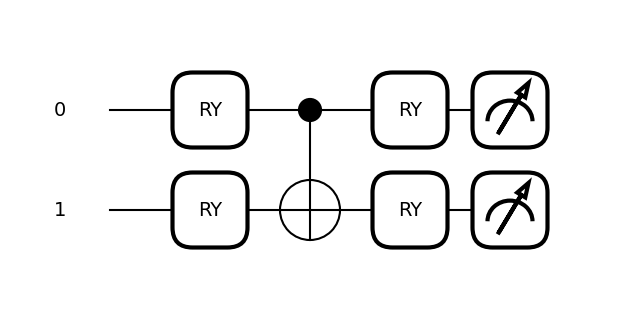

In [7]:
dev_draw = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_draw)
def ansatz_circuit(params):
    ansatz(params, wires=range(n_qubits))
    return qml.state()

# Example parameters (just for visualization)
example_params = np.array([0.3, 0.2, -0.4, 0.1])

qml.draw_mpl(ansatz_circuit)(example_params)

## Energy expectation QNode

In [8]:
dev_vqe = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev_vqe)
def energy_qnode(params):
    ansatz(params, wires=range(n_qubits))
    return qml.expval(H)

## Classical optimisation loop

In [9]:
np.random.seed(0)
params = np.random.normal(0, 0.1, size=4, requires_grad=True)
energies = []

opt = qml.AdamOptimizer(stepsize=0.2)

for step in range(50):
    params, energy = opt.step_and_cost(energy_qnode, params)
    energies.append(float(energy))
    print(f"Step {step:02d}: E = {energy:.6f} Ha")

vqe_energy = energies[-1]

Step 00: E = 0.675437 Ha
Step 01: E = 0.492528 Ha
Step 02: E = 0.206750 Ha
Step 03: E = -0.140865 Ha
Step 04: E = -0.494036 Ha
Step 05: E = -0.794802 Ha
Step 06: E = -1.000522 Ha
Step 07: E = -1.098555 Ha
Step 08: E = -1.108339 Ha
Step 09: E = -1.067263 Ha
Step 10: E = -1.010563 Ha
Step 11: E = -0.959694 Ha
Step 12: E = -0.923058 Ha
Step 13: E = -0.901727 Ha
Step 14: E = -0.893889 Ha
Step 15: E = -0.896969 Ha
Step 16: E = -0.908366 Ha
Step 17: E = -0.925635 Ha
Step 18: E = -0.946504 Ha
Step 19: E = -0.968917 Ha
Step 20: E = -0.991130 Ha
Step 21: E = -1.011841 Ha
Step 22: E = -1.030276 Ha
Step 23: E = -1.046177 Ha
Step 24: E = -1.059672 Ha
Step 25: E = -1.071089 Ha
Step 26: E = -1.080791 Ha
Step 27: E = -1.089075 Ha
Step 28: E = -1.096136 Ha
Step 29: E = -1.102067 Ha
Step 30: E = -1.106866 Ha
Step 31: E = -1.110459 Ha
Step 32: E = -1.112740 Ha
Step 33: E = -1.113646 Ha
Step 34: E = -1.113232 Ha
Step 35: E = -1.111731 Ha
Step 36: E = -1.109563 Ha
Step 37: E = -1.107270 Ha
Step 38: E = -1

## VQE convergence

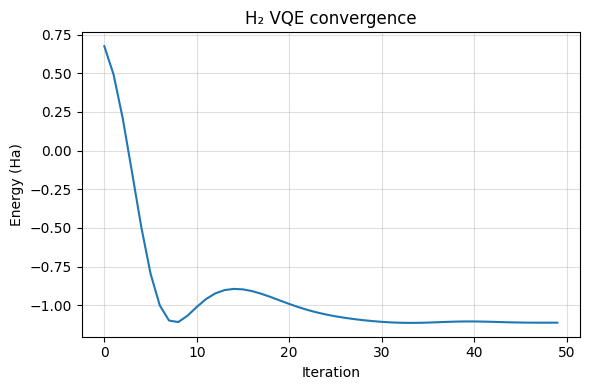

Final VQE energy: -1.11229067 Ha


In [10]:
plt.figure(figsize=(6, 4))
plt.plot(energies)
plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("H₂ VQE convergence")
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()

print(f"Final VQE energy: {vqe_energy:.8f} Ha")

---
# Part II — Quantum Phase Estimation (QPE)
---

## Controlled time evolution

We approximate:

    U(t) = exp(-i H t)

using first-order Trotterization.

In [11]:
def controlled_time_evolution(H, t, control, system_wires):
    qml.ctrl(qml.ApproxTimeEvolution, control=control)(
        H, t, 1
    )
    

## Inverse Quantum Fourier Transform

In [12]:
def inverse_qft(wires):
    n = len(wires)
    for i in range(n // 2):
        qml.SWAP(wires=[wires[i], wires[n - i - 1]])
    for j in range(n):
        k = n - j - 1
        qml.Hadamard(wires=k)
        for m in range(k):
            angle = -np.pi / (2 ** (k - m))
            qml.ControlledPhaseShift(angle, wires=[wires[m], wires[k]])

## QPE circuit

In [13]:
n_ancilla = 4
t = 1.0
shots = 3000

dev_qpe = qml.device(
    "default.qubit",
    wires=n_qubits + n_ancilla,
    shots=shots,
)

ancilla_wires = list(range(n_ancilla))
system_wires = list(range(n_ancilla, n_ancilla + n_qubits))

# Map Hamiltonian onto system register
wire_map = {i: system_wires[i] for i in range(n_qubits)}
H_sys = H.map_wires(wire_map)

@qml.qnode(dev_qpe)
def qpe_circuit():
    # Prepare HF state
    qml.BasisState(hf_state, wires=system_wires)

    # Hadamards on ancillas
    for a in ancilla_wires:
        qml.Hadamard(wires=a)

    # Controlled-U ladder
    for k, a in enumerate(ancilla_wires):
        power = n_ancilla - 1 - k
        for _ in range(2 ** power):
            controlled_time_evolution(H_sys, t, a, system_wires)

    # Inverse QFT
    inverse_qft(ancilla_wires)

    return qml.sample(wires=ancilla_wires)

/home/codespace/.local/lib/python3.12/site-packages/pennylane/devices/device_api.py:193: PennyLaneDeprecationWarning: Setting shots on device is deprecated. Please use the `set_shots` transform on the respective QNode instead.
  warnings.warn(


## QPE Circuit Drawing

/tmp/ipykernel_24221/3724654988.py:3: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


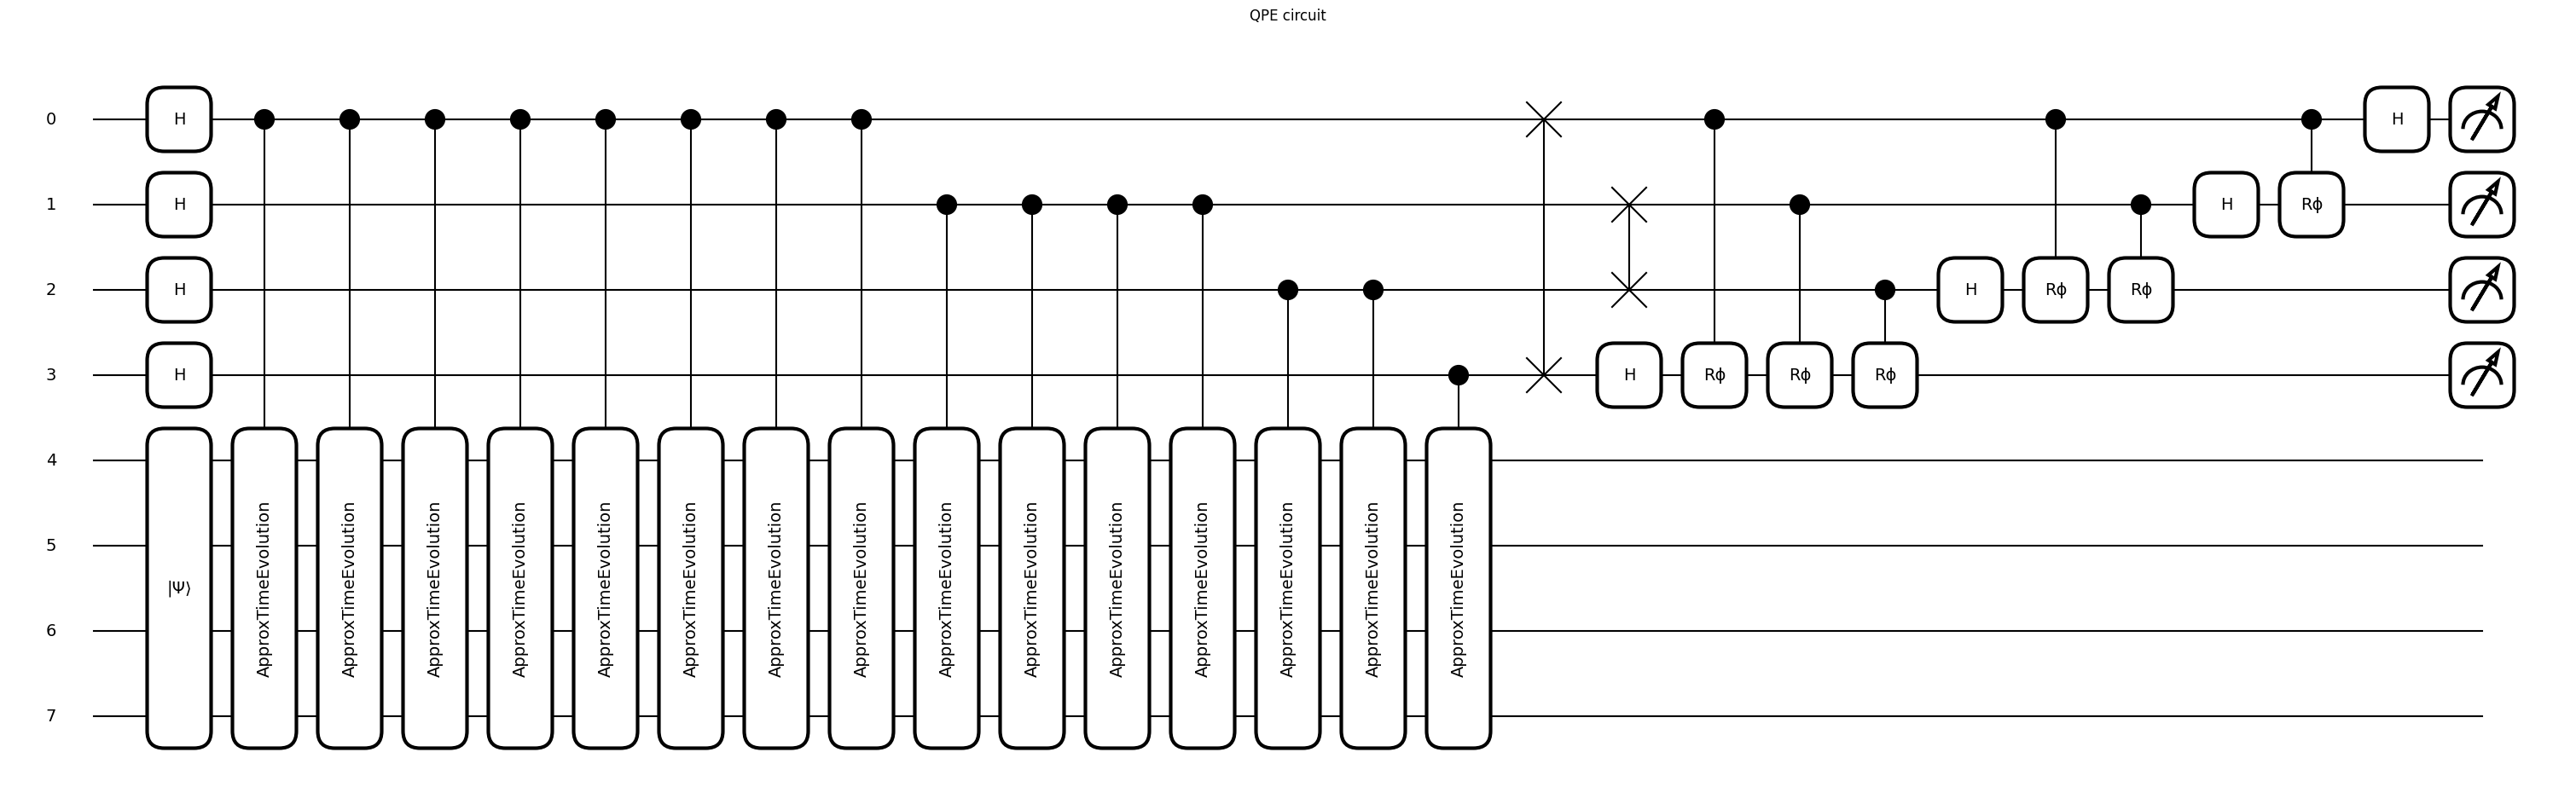

In [14]:
fig, ax = qml.draw_mpl(qpe_circuit)()
ax.set_title("QPE circuit", pad=12)
fig.tight_layout()


## Run QPE

In [15]:
samples = np.array(qpe_circuit(), dtype=int)
bitstrings = ["".join(str(b) for b in s) for s in samples]

counts = {}
for b in bitstrings:
    counts[b] = counts.get(b, 0) + 1

probs = {b: c / shots for b, c in counts.items()}

# Most likely outcome
best_bitstring = max(probs, key=probs.get)
print(f"Most probable bitstring: {best_bitstring}")

Most probable bitstring: 0011


## Phase → energy

In [19]:
def bitstring_to_phase(bits):
    bits = str(bits)
    return sum(int(b) * 0.5 ** (i + 1) for i, b in enumerate(bits))

def phase_to_energy(phase, t):
    return -2 * np.pi * phase / t

def ket_label(bits):
    return f"|{bits}⟩"

# Compute phase/energy for every observed bitstring
items = []
for b, p in probs.items():
    ph = bitstring_to_phase(b)
    E = phase_to_energy(ph, t)
    items.append((b, p, ph, E))

# Sort by energy (ascending)
items.sort(key=lambda x: x[3])

# Most likely outcome
best_bitstring = max(probs, key=probs.get)
best_phase = bitstring_to_phase(best_bitstring)
qpe_energy = phase_to_energy(best_phase, t)

print(f"Most probable state: {ket_label(best_bitstring)}")
print(f"Estimated phase    : {best_phase:.6f}")
print(f"QPE energy         : {qpe_energy:.8f} Ha")


Most probable state: |0011⟩
Estimated phase    : 0.187500
QPE energy         : -1.17809725 Ha


## QPE distribution

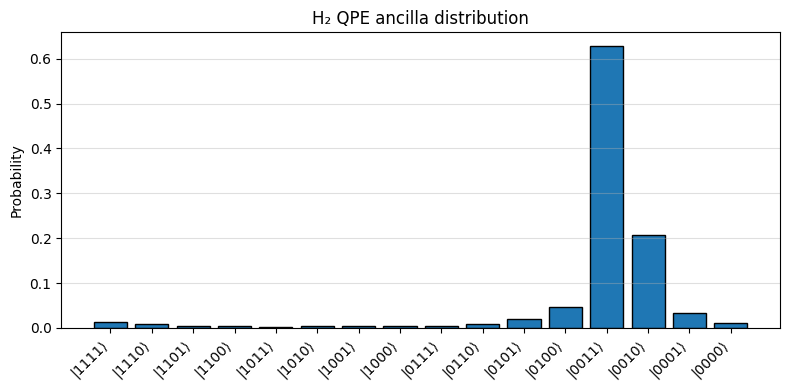

In [20]:
labels = [ket_label(b) for (b, p, ph, E) in items]
values = [p for (b, p, ph, E) in items]

plt.figure(figsize=(8, 4))
plt.bar(labels, values, edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Probability")
plt.title("H₂ QPE ancilla distribution")
plt.grid(axis="y", alpha=0.4)
plt.tight_layout()
plt.show()


---
# Final comparison
---

In [18]:
print("=== Final comparison ===")
print(f"VQE energy : {vqe_energy:.8f} Ha")
print(f"QPE energy : {qpe_energy:.8f} Ha")


=== Final comparison ===
VQE energy : -1.11229067 Ha
QPE energy : -1.17809725 Ha
